In [191]:
import json

# Load Emotiv data
with open('metlog.json') as emotiv_file:
    emotiv_data = json.load(emotiv_file)

# Load gaze data
with open('raw_data.json') as gaze_file:
    gaze_data = json.load(gaze_file)

x_gaze = [data['xprediction'] for data in gaze_data.values()]
y_gaze = [data['yprediction'] for data in gaze_data.values()]
    

# Ignoring possible errors and outliers

In [192]:
import numpy as np
from PIL import Image

# Load the background image
bg_image = Image.open("bg.jpg")
img_width, img_height = bg_image.size
# Combine the raw gaze data into a single array of XY coordinates
gaze_data_xy = np.array(list(zip(x_gaze, y_gaze)))

# Filter out-of-bounds predictions
valid_indices = (gaze_data_xy[:, 0] >= 0) & (gaze_data_xy[:, 0] <= img_width) & (gaze_data_xy[:, 1] >= 0) & (gaze_data_xy[:, 1] <= img_height)
gaze_data_filtered = gaze_data_xy[valid_indices]

# Get the filtered XY coordinates
x_gaze_filtered = gaze_data_filtered[:, 0]
y_gaze_filtered = gaze_data_filtered[:, 1]
print("Pre filtering:")
print("X min", np.array(x_gaze).min())
print("Y min", np.array(y_gaze).min())
print("X max", np.array(x_gaze).max())
print("Y max", np.array(y_gaze).max())
print("---------------")
print("Post filtering:")
print("X min", x_gaze_filtered.min())
print("Y min", y_gaze_filtered.min())
print("X max", x_gaze_filtered.max())
print("Y max", y_gaze_filtered.max())
x_gaze = x_gaze_filtered
y_gaze = y_gaze_filtered
gaze_data_xy = np.array(list(zip(x_gaze, y_gaze)))


Pre filtering:
X min -97.7384831945475
Y min -302.16466599650073
X max 2261.4647430152827
Y max 1163.619016125828
---------------
Post filtering:
X min 8.309373832803304
Y min 6.553922317088379
X max 1919.253139418049
Y max 1072.6455834186152


# Preprocessing the gaze data using DBSCAN clustering

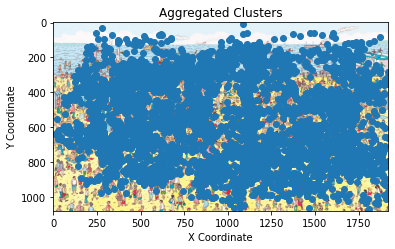

In [194]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Convert the timestamps in gaze_data to floats
timestamps_gaze = [float(timestamp) for timestamp in gaze_data.keys()]

# Segment the data into 500ms intervals
time_interval = 5  # seconds
num_intervals = int(np.ceil(max(timestamps_gaze) / time_interval))

# Create lists to store aggregated cluster coordinates
aggregated_x_cluster = []
aggregated_y_cluster = []

for i in range(num_intervals):
    interval_start = i * time_interval
    interval_end = (i + 1) * time_interval

    # Filter the gaze data within the time interval
    indices_interval = [j for j, timestamp in enumerate(timestamps_gaze) if interval_start <= timestamp < interval_end]
    if indices_interval and indices_interval[0] >= len(gaze_data_xy):
        continue
    gaze_data_interval_xy = gaze_data_xy[indices_interval]

    # Check if there are any gaze points within the interval
    if len(gaze_data_interval_xy) > 0:
        if len(gaze_data_interval_xy) == 1:
            # If there is only one gaze point, store it as a separate cluster
            aggregated_x_cluster.extend([gaze_data_interval_xy[0, 0]])
            aggregated_y_cluster.extend([gaze_data_interval_xy[0, 1]])
        else:
            # Apply DBSCAN clustering
            epsilon = 20  # Maximum distance between points to be considered in the same neighborhood
            min_samples = 15  # Minimum number of points required to form a dense region
            dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
            labels = dbscan.fit_predict(gaze_data_interval_xy)

            # Aggregate the cluster coordinates for the current interval
            for label in set(labels):
                label_indices = (labels == label)
                aggregated_x_cluster.extend(gaze_data_interval_xy[label_indices, 0])
                aggregated_y_cluster.extend(gaze_data_interval_xy[label_indices, 1])

# Plot the aggregated clusters
fig, ax = plt.subplots()

# Display the background image
ax.imshow(background_img)

# Plot the aggregated clusters
ax.scatter(aggregated_x_cluster, aggregated_y_cluster, label='Aggregated Clusters')

# Set the labels and title for the plot
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_title('Aggregated Clusters')

# Show the plot
plt.show()


# Create success labels

In [195]:
# Define the location of Waldo
waldo_x, waldo_y = 1340, 484

# Define the AOI radius
aoi_radius = 100

# Create the success_labels list
success_labels = []

# Iterate over the gaze points and compare the distance to the defined location
for x, y in zip(x_gaze_filtered, y_gaze_filtered):
    distance = np.sqrt((x - waldo_x)**2 + (y - waldo_y)**2)
    
    if distance <= aoi_radius:
        success_labels.append(True)
    else:
        success_labels.append(False)


# Question 1: What is the average time taken by the user to locate Waldo?


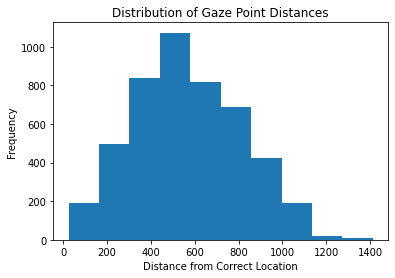

Average time taken: 569.1763141664155


In [196]:
import matplotlib.pyplot as plt

# Assuming the correct location of Waldo is (x_correct, y_correct)
x_correct = 1340
y_correct = 484

# Calculate the Euclidean distance between each gaze point and the correct location of Waldo
distances = []
for timestamp, gaze_point in gaze_data.items():
    x_prediction = gaze_point['xprediction']
    y_prediction = gaze_point['yprediction']
    distance = ((x_prediction - x_correct)**2 + (y_prediction - y_correct)**2)**0.5
    distances.append(distance)

# Calculate the average time taken
average_time = sum(distances) / len(distances)

# Create a histogram of the distances
plt.hist(distances, bins=10)
plt.xlabel('Distance from Correct Location')
plt.ylabel('Frequency')
plt.title('Distribution of Gaze Point Distances')
plt.show()

print("Average time taken:", average_time)


# Question 2: How does the user's engagement level (eng) change over time during the activity?


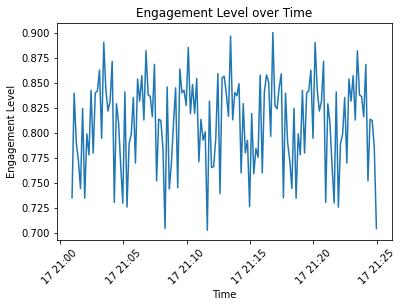

In [197]:
import datetime
import matplotlib.pyplot as plt

# Extract timestamps and eng values from the Emotiv data
timestamps = [entry['time'] for entry in emotiv_data]
eng_values = [entry['eng'] for entry in emotiv_data]

# Convert timestamps to datetime objects
datetime_timestamps = [datetime.datetime.fromtimestamp(timestamp) for timestamp in timestamps]

# Plot the eng values over time
plt.plot(datetime_timestamps, eng_values)
plt.xlabel('Time')
plt.ylabel('Engagement Level')
plt.title('Engagement Level over Time')
plt.xticks(rotation=45)
plt.show()


# Question 3: Is there a correlation between the user's engagement level (eng) and their gaze distance from the correct location of Waldo?



[0.842964, 0.845221, 0.77238, 0.798832, 0.779539, 0.862683, 0.831346, 0.810476, 0.789049, 0.769635, 0.857042, 0.836229, 0.751881, 0.785149]


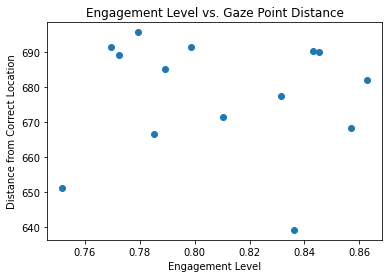

Correlation between engagement level and gaze point distance: -0.04928897519433469


In [201]:
import datetime
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Extract the starting timestamp from the Emotiv data
starting_timestamp_emotiv = emotiv_data[0]['time']

# Adjust the timestamps in the gaze data
adjusted_gaze_data = {}
starting_timestamp_gaze = 0  # Set the gaze data starting timestamp to zero
for timestamp, gaze_point in gaze_data.items():
    adjusted_timestamp = float(timestamp) - starting_timestamp_gaze
    adjusted_gaze_data[adjusted_timestamp] = gaze_point

# Extract timestamps and eng values from the Emotiv data
timestamps_emotiv = [entry['time'] - starting_timestamp_emotiv for entry in emotiv_data]
eng_values = [entry['eng'] for entry in emotiv_data]

# Convert timestamps to datetime objects
datetime_timestamps_emotiv = [datetime.datetime.fromtimestamp(timestamp + starting_timestamp_emotiv) for timestamp in timestamps_emotiv]

# Match eng values and distances based on the 5s window around each Emotiv data timestamp
eng_values_matched = []
distances_matched = []
for timestamp in timestamps_emotiv:
    closest_timestamp = min(adjusted_gaze_data.keys(), key=lambda x: abs(x - timestamp))
    if abs(closest_timestamp - timestamp) <= 5:
        eng_values_matched.append(eng_values[timestamps_emotiv.index(timestamp)])
        distances_matched.append(((adjusted_gaze_data[closest_timestamp]['xprediction'] - x_correct)**2 + (adjusted_gaze_data[closest_timestamp]['yprediction'] - y_correct)**2)**0.5)
print(eng_values_matched)
# Check if the length is sufficient for correlation analysis
if len(eng_values_matched) >= 2:
    # Calculate the correlation between eng values and distances from the correct location
    correlation, _ = stats.pearsonr(eng_values_matched, distances_matched)

    # Create a scatter plot to visualize the relationship
    plt.scatter(eng_values_matched, distances_matched)
    plt.xlabel('Engagement Level')
    plt.ylabel('Distance from Correct Location')
    plt.title('Engagement Level vs. Gaze Point Distance')
    plt.show()

    print("Correlation between engagement level and gaze point distance:", correlation)
else:
    print("Insufficient data points for correlation analysis.")


# Question 4: How does the engagement level vary with the gaze point over time in different intervals?



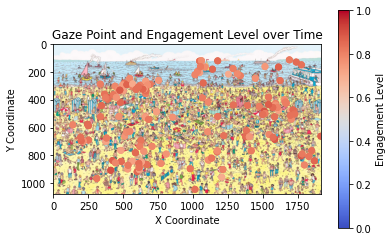

In [199]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Load the background image
background_img = mpimg.imread('bg.jpg')

# Set up the figure and axis
fig, ax = plt.subplots()

# Display the background image
ax.imshow(background_img)

# Set the labels and title
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_title('Gaze Point and Engagement Level over Time')

# Segment the data into time intervals (e.g., every 10 seconds)
time_interval = 10  # seconds
num_intervals = int(np.ceil(timestamps_emotiv[-1] / time_interval))

for i in range(num_intervals):
    interval_start = i * time_interval
    interval_end = (i + 1) * time_interval

    # Filter the gaze data and engagement level within the time interval
    filtered_gaze_x = []
    filtered_gaze_y = []
    filtered_eng = []
    for j in range(len(timestamps_emotiv)):
        if interval_start <= timestamps_emotiv[j] <= interval_end:
            filtered_gaze_x.append(x_gaze[j])
            filtered_gaze_y.append(y_gaze[j])
            filtered_eng.append(eng_values[j])

    # Plot the filtered gaze data and engagement level within the time interval
    ax.scatter(filtered_gaze_x, filtered_gaze_y, c=filtered_eng, cmap='coolwarm', vmin=0, vmax=1, label=f'Time Interval: {interval_start}-{interval_end} sec')

# Add a colorbar legend
cbar = plt.colorbar(ax.scatter([], [], c=[], cmap='coolwarm', vmin=0, vmax=1))
cbar.set_label('Engagement Level')

# Add a legend

# Show the plot
plt.show()


# Question 5: How does the average engagement level change over time?



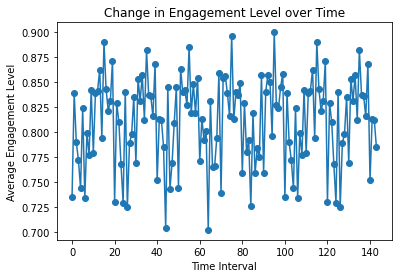

In [181]:
# Calculate the average engagement level in each time interval
avg_engagement_levels = []
for i in range(num_intervals):
    interval_start = i * time_interval
    interval_end = (i + 1) * time_interval

    # Filter the engagement level within the time interval
    eng_values_interval = [eng for eng, timestamp in zip(eng_values, timestamps_emotiv) if interval_start <= timestamp < interval_end]

    # Calculate the average engagement level in the interval
    avg_engagement = np.mean(eng_values_interval)
    
    avg_engagement_levels.append(avg_engagement)

# Plot the average engagement levels over time
plt.plot(range(num_intervals), avg_engagement_levels, marker='o')

# Set the labels and title for the plot
plt.xlabel('Time Interval')
plt.ylabel('Average Engagement Level')
plt.title('Change in Engagement Level over Time')

# Show the plot
plt.show()


# Question 6: How do the gaze points for successful and unsuccessful findings differ in their distribution?

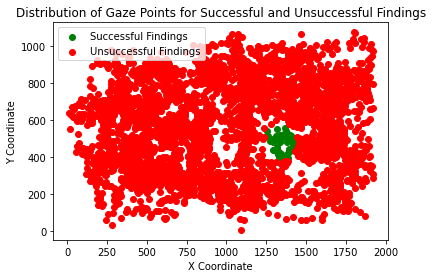

In [182]:
# Separate successful and unsuccessful findings based on a condition
successful_findings = [(x, y) for x, y, success in zip(x_gaze_filtered, y_gaze_filtered, success_labels) if success]
unsuccessful_findings = [(x, y) for x, y, success in zip(x_gaze_filtered, y_gaze_filtered, success_labels) if not success]

# Create a scatter plot for successful findings
x_success = [point[0] for point in successful_findings]
y_success = [point[1] for point in successful_findings]
plt.scatter(x_success, y_success, color='green', label='Successful Findings')

# Create a scatter plot for unsuccessful findings
x_unsuccess = [point[0] for point in unsuccessful_findings]
y_unsuccess = [point[1] for point in unsuccessful_findings]
plt.scatter(x_unsuccess, y_unsuccess, color='red', label='Unsuccessful Findings')

# Set the labels and title for the plot
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Distribution of Gaze Points for Successful and Unsuccessful Findings')

# Add a legend
plt.legend()

# Show the plot
plt.show()


# Question 7: How do the engagement levels differ between successful and unsuccessful findings?



In [183]:
# Calculate the mean or median engagement level for successful and unsuccessful findings
mean_eng_success = np.mean([eng for eng, success in zip(eng_values, success_labels) if success])
mean_eng_unsuccess = np.mean([eng for eng, success in zip(eng_values, success_labels) if not success])

median_eng_success = np.median([eng for eng, success in zip(eng_values, success_labels) if success])
median_eng_unsuccess = np.median([eng for eng, success in zip(eng_values, success_labels) if not success])

# Print the mean and median engagement levels
print(f"Mean Engagement Level - Successful Findings: {mean_eng_success}")
print(f"Mean Engagement Level - Unsuccessful Findings: {mean_eng_unsuccess}")
print(f"Median Engagement Level - Successful Findings: {median_eng_success}")
print(f"Median Engagement Level - Unsuccessful Findings: {median_eng_unsuccess}")


Mean Engagement Level - Successful Findings: 0.8403484999999999
Mean Engagement Level - Unsuccessful Findings: 0.8098088181818182
Median Engagement Level - Successful Findings: 0.8403484999999999
Median Engagement Level - Unsuccessful Findings: 0.816351
